In [3]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import numpy as np
import re

In [137]:
business_lv = pd.read_csv("./data/final_business.csv")
#inspection_lv = pd.read_csv('./data/inspection_lv.csv')
#restaurants_categories = ["Restaurant", "Bar / Tavern", "Snack Bar", "Special Kitchen", \
#                          "Buffet", "Barbeque", "Banquet Kitchen", "Bakery Sales", "Kitchen Bakery", \
#                         "Kitchen Bakery", "Portable Bar", "Confection"]
#inspection_lv = inspection_lv[inspection_lv['Category Name'].isin(restaurants_categories)]
#business_lv = business_lv[business_lv['business_id'].isin(inspection_lv['Nearest_yelp_id'])]
#business_lv.index = np.arange(business_lv.shape[0])

In [31]:
business_lv.loc[3, 'name']

'Los Cucos Mexican Cafe'

In [50]:
strarr = re.sub('[^a-zA-Z0-9\n\.]', ' ', business_lv.loc[2, 'name']).split(' ')
strnew = ""
for s in strarr:
    if s != '':
        strnew = strnew + s +  "+"
print(strnew)

Marie+Callender+s+Restaurant+Bakery+


u'<!DOCTYPE HTML>\n\n<!--[if lt IE 7 ]> <html xmlns:fb="http://www.facebook.com/2008/fbml" class="ie6 ie ltie9 ltie8 no-js" lang="en"> <![endif]-->\n<!--[if IE 7 ]>    <html xmlns:fb="http://www.facebook.com/2008/fbml" class="ie7 ie ltie9 ltie8 no-js" lang="en"> <![endif]-->\n<!--[if IE 8 ]>    <html xmlns:fb="http://www.facebook.com/2008/fbml" class="ie8 ie ltie9 no-js" lang="en"> <![endif]-->\n<!--[if IE 9 ]>    <html xmlns:fb="http://www.facebook.com/2008/fbml" class="ie9 ie no-js" lang="en"> <![endif]-->\n<!--[if (gt IE 9)|!(IE)]><!--> <html xmlns:fb="http://www.facebook.com/2008/fbml" class="no-js" lang="en"> <!--<![endif]-->\n    <head>\n            <script>\n            (function() {\n                var main = null;\n\n                var main=function(a){window.onerror=(function(){var c=function(e){return function(){var f;if(Array.prototype.toJSON){f=Array.prototype.toJSON;delete Array.prototype.toJSON}e.apply(this,arguments);if(f){Array.prototype.toJSON=f}}};var d=function(){
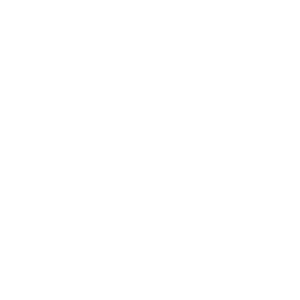
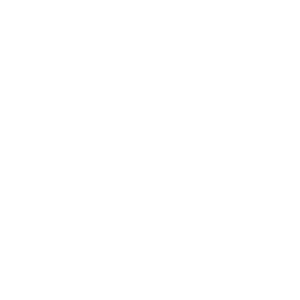
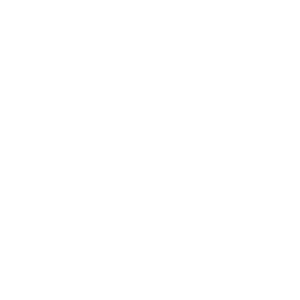
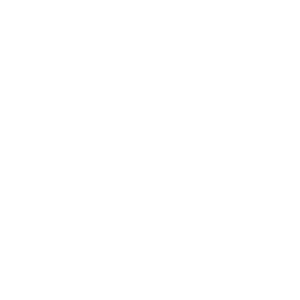
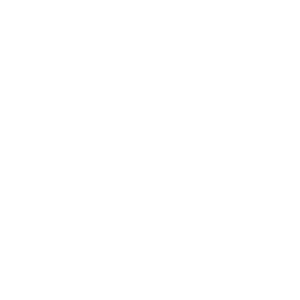
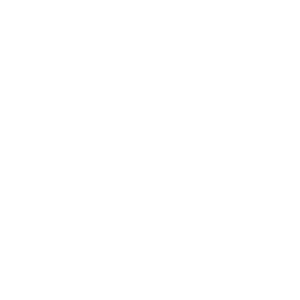
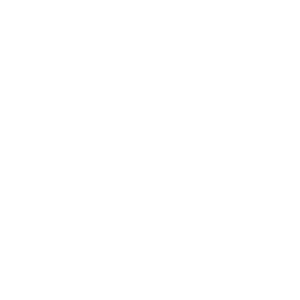
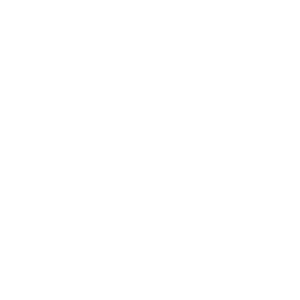

In [56]:
# replace special characters and space with '+'
def reset_restaurant_name(name):
    strarr = re.sub('[^a-zA-Z0-9\n\.]', ' ', name).split(' ')
    strnew = ""
    for s in strarr:
        if s != '':
            strnew = strnew + s + "+"
    return strnew

# https://www.yelp.com/search?find_desc=Los+Cucos+Mexican+Cafe+&find_loc=Las+Vegas,+NV
# Return webpage.text given the restaurant name and location
def get_search_page_html(find_desc, find_loc):
    link = 'https://www.yelp.com/search?find_desc=' + find_desc + '&find_loc=' + find_loc
    headers = {'User-Agent': 'Mozilla/5.0 (Windows; U; Windows NT 6.1; en-US; rv:1.9.1.6) Gecko/20091201 Firefox/3.5.6'}
    r = requests.get(link, headers = headers)
    return(r.text)
    
get_search_page_html('Los+Cucos+Mexican+Cafe+', 'Las+Vegas,+NV')

In [189]:
# return the dollar-sign of the restaurant as integer value: 1, 2, 3, ...
def get_dollar_sign_link(text, business_index):
    soup = BeautifulSoup(text, 'html.parser')
    row = soup.find_all("div", class_="biz-listing-large")
    dollar_sign = None
    restaurant_link = None
    for r in row:
        rsec = r.find("div", class_="secondary-attributes")
        if(rsec.find("address")):
            addr = rsec.find("address").text     
            addrnum = re.sub('[^0-9\.]', ' ', addr).split(' ')
            for a in addrnum:
                if a == '':
                    continue
                else:
                    number = a
                    break
            if number == business_lv.loc[business_index, 'address'].split(' ')[0]:
                rprice = r.find("div", class_="price-category")
                if rprice.find("span", class_="business-attribute price-range"):
                    dollar_sign = len(rprice.find("span", class_="business-attribute price-range").text)
                if r.find("span", class_="indexed-biz-name"):
                    restaurant_link = 'https://www.yelp.com' + r.find("span", class_="indexed-biz-name").a['href']
                break;   
    return dollar_sign, restaurant_link

In [244]:
#print(business_lv.loc[2, 'neighborhood']+',+Las+Vegas,+NV')
get_dollar_sign_link(get_search_page_html(reset_restaurant_name(business_lv.loc[8, 'name']), business_lv.loc[8, 'neighborhood']+',+Las+Vegas,+NV'), 8)
#print('https://www.yelp.com/search?find_desc=' + reset_restaurant_name(business_lv.loc[2, 'name']) + '&find_loc=' + business_lv.loc[2, 'neighborhood']+',+Las+Vegas,+NV')
      
      

(None, None)

In [251]:
business_lv['dollar_sign'] = -9999
business_lv['yelp_link'] = -9999
for i in np.arange(business_lv.shape[0]):
    business_lv.loc[i, ['dollar_sign', 'yelp_link']] = get_dollar_sign_link(get_search_page_html(reset_restaurant_name(business_lv.loc[i, 'name']), 'Las+Vegas,+NV'), i)
    # if yelp_link not searched, refine search by adding district
    if (not business_lv.loc[i, 'yelp_link']) and (business_lv.loc[i, 'neighborhood']): 
        business_lv.loc[i, ['dollar_sign', 'yelp_link']] = get_dollar_sign_link(get_search_page_html(reset_restaurant_name(business_lv.loc[i, 'name']), str(business_lv.loc[i, 'neighborhood'])+',+Las+Vegas,+NV'), i)
    if i%10 == 0:
        time.sleep(1)

In [253]:
business_lv['yelp_link'].isnull().sum()
#business_lv['dollar_sign'].isnull().sum()

203

In [194]:
print('https://www.yelp.com/search?find_desc=' + reset_restaurant_name(business_lv.loc[8, 'name']) + '&find_loc=' + 'Las+Vegas,+NV')

https://www.yelp.com/search?find_desc=Carl+s+Jr+&find_loc=Las+Vegas,+NV
<div class="price-category">
<span class="category-str-list">
<a href="/search?cflt=wedding_planning&amp;find_desc=The+Ritz+of+Las+Vegas&amp;find_loc=Las+Vegas%2C+NV">Wedding Planning</a>,
                    <a href="/search?cflt=venues&amp;find_desc=The+Ritz+of+Las+Vegas&amp;find_loc=Las+Vegas%2C+NV">Venues &amp; Event Spaces</a>
</span>
</div>


In [11]:
#business_lv = pd.read_csv('./data/final_business_yelplink.csv')
yelplink_notnull = (business_lv[business_lv['yelp_link'].isnull()])
yelplink_notnull[yelplink_notnull.neighborhood.isnull()]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,address,attributes,business_id,categories,city,hours,is_open,...,longitude,name,neighborhood,postal_code,review_count,stars,state,geometry,dollar_sign,yelp_link
17,17,512,512,6235 S Decatur Blvd,"{u'Alcohol': u'full_bar', u'HasTV': True, u'No...",9hEPwq1GmU1dp3ZyBB9ASQ,"[Restaurants, Sports Bars, Nightlife, American...",Las Vegas,"{u'Monday': u'0:00-0:00', u'Tuesday': u'0:00-0...",1,...,-115.208783,PT's,NaN,89118.0,40,3.0,NV,POINT (-115.2087831 36.0764517),NaN,NaN
56,56,1775,1775,7210 W Lake Mead Blvd,"{u'GoodForMeal': {u'dessert': False, u'latenig...",SXfb2X6nTPC-IPhPiIi4Ww,"[Sandwiches, Food Delivery Services, Delis, Re...",Las Vegas,"{u'Monday': u'10:00-21:00', u'Tuesday': u'10:0...",0,...,-115.249198,Jimmy John's,NaN,89128.0,50,3.5,NV,POINT (-115.2491981 36.1967709),NaN,NaN
59,59,1935,1935,4380 N Nellis Blvd,"{u'GoodForMeal': {u'dessert': False, u'latenig...",HXCCITejNvcqtjNQRHnMPw,"[Mexican, Restaurants]",Las Vegas,{},1,...,-115.061421,Del Taco,NaN,89115.0,7,3.0,NV,POINT (-115.0614211 36.2400326),NaN,NaN
61,61,1956,1956,4889 E Craig Rd,"{u'RestaurantsPriceRange2': 2, u'GoodForKids':...",UNVYKGIq6jwcAnP1sT7jgg,"[Mexican, Restaurants]",Las Vegas,{},0,...,-115.067143,Harry's Dora Maria Family Restaurant,NaN,89115.0,5,4.0,NV,POINT (-115.067143 36.240065),NaN,NaN
63,63,2009,2009,1501 W Lake Mead Blvd,"{u'GoodForMeal': {u'dessert': False, u'latenig...",kB1S2GJUjE2k3XN1WQS9tQ,"[Fast Food, Restaurants, Burgers]",Las Vegas,{},1,...,-115.161151,McDonald's,NaN,89106.0,15,1.5,NV,POINT (-115.1611508 36.1953052),NaN,NaN
85,85,2656,2656,844 N Rancho Dr,"{u'BusinessParking': {u'garage': False, u'stre...",nhjYGdlR5Yw5-uOQqCVF8A,"[Burgers, Hot Dogs, Fast Food, Restaurants]",Las Vegas,{},1,...,-115.178365,Wendy's,NaN,89106.0,7,1.5,NV,POINT (-115.178365 36.180793),NaN,NaN
147,147,4321,4321,831 N Rancho Dr,"{u'GoodForMeal': {u'dessert': False, u'latenig...",oUso4QWH1OAXboD8IMjpFQ,"[Restaurants, Mexican]",Las Vegas,"{u'Monday': u'0:00-0:00', u'Tuesday': u'0:00-0...",0,...,-115.178550,Molcasalsa Mexican Food,NaN,89106.0,13,4.0,NV,POINT (-115.1785503 36.1801087),NaN,NaN
155,155,4550,4550,4966 Boulder Hwy,"{u'GoodForMeal': {u'dessert': False, u'latenig...",qParPpAesanzrvjhFV0PdQ,"[Seafood, Fast Food, Restaurants]",Las Vegas,{},0,...,-115.065618,Long John Silver's,NaN,89121.0,9,2.5,NV,POINT (-115.0656175 36.1131443),NaN,NaN
159,159,4751,4751,5526 Boulder Hwy,"{u'GoodForMeal': {u'dessert': False, u'latenig...",OM31QC8tyTOXZgK0FDz_hw,"[Restaurants, Mexican]",Las Vegas,{},1,...,-115.053142,Del Taco,NaN,89122.0,23,3.0,NV,POINT (-115.053142111 36.1020815564),NaN,NaN
169,169,5011,5011,600 Jackson Ave,"{u'BusinessParking': {u'garage': False, u'stre...",EV85dKbe4lYRC3Mo4rNXVQ,"[Nightlife, Arts & Entertainment, Casinos, Div...",Las Vegas,{},0,...,-115.149827,New Town Tavern,NaN,89106.0,3,4.5,NV,POINT (-115.149827 36.186195),NaN,NaN


In [256]:
#business_lv.to_csv('./data/final_business_yelplink.csv', encoding = 'utf-8')